In [23]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import os
import cv2
import fnmatch
import pydot
import itertools
import functools

In [2]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [3]:
img_width, img_height = 299, 299

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)


valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
train_batches = train_datagen.flow_from_directory(train_path, 
                                                  target_size=(img_width, img_height), 
                                                  classes=['dog','cat'], 
                                                  batch_size=80)

valid_batches = valid_datagen.flow_from_directory(valid_path, 
                                                  target_size=(img_width, img_height), 
                                                  classes=['dog','cat'], 
                                                  batch_size=10)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(img_width, img_height), 
                                                        classes=['dog','cat'], 
                                                        batch_size=20)

Found 400 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
# Functional API model

type(inceptionV3)

keras.engine.training.Model

In [16]:
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'
# plot_model(model_inception, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.3)(x)
# x = Dense(512, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
model.compile(loss="categorical_crossentropy", optimizer = 'rmsprop', metrics=['accuracy'])

In [16]:
model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=5, epochs=5, steps_per_epoch=5, verbose=1)

Epoch 1/5
5/5 [==============================] - 437s 87s/step - loss: 0.6822 - acc: 0.6550 - val_loss: 0.3086 - val_acc: 0.9600
Epoch 2/5
5/5 [==============================] - 365s 73s/step - loss: 0.4136 - acc: 0.8500 - val_loss: 0.2926 - val_acc: 0.9000
Epoch 3/5
5/5 [==============================] - 409s 82s/step - loss: 0.3581 - acc: 0.8850 - val_loss: 0.3358 - val_acc: 0.8000
Epoch 4/5
5/5 [==============================] - 432s 86s/step - loss: 0.3074 - acc: 0.9050 - val_loss: 0.3052 - val_acc: 0.8600
Epoch 5/5
5/5 [==============================] - 421s 84s/step - loss: 0.2807 - acc: 0.9200 - val_loss: 0.2266 - val_acc: 0.8800


In [17]:
def plots(ims, figsize=(12,6), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

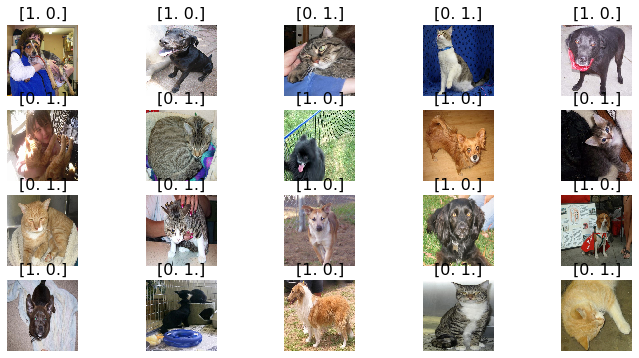

In [32]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [19]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 1.], dtype=float32)

In [21]:
predictions = model.predict_generator(test_batches, steps=1, verbose=1)

1/1 [==============================] - 22s 22s/step


In [31]:
print(predictions)

[[1.4025515e-02 9.8597449e-01]
 [1.1361110e-19 1.0000000e+00]
 [3.3172643e-07 9.9999964e-01]
 [2.0402411e-05 9.9997962e-01]
 [1.0155846e-06 9.9999893e-01]
 [1.8904450e-07 9.9999976e-01]
 [7.9186398e-19 1.0000000e+00]
 [9.9999988e-01 1.0358350e-07]
 [2.1251205e-06 9.9999785e-01]
 [1.3604982e-02 9.8639500e-01]
 [2.0310560e-10 1.0000000e+00]
 [6.5532148e-02 9.3446791e-01]
 [1.3882149e-02 9.8611790e-01]
 [5.0220689e-15 1.0000000e+00]
 [1.1401251e-11 1.0000000e+00]
 [7.9835889e-09 1.0000000e+00]
 [2.3152122e-01 7.6847875e-01]
 [1.6467785e-08 1.0000000e+00]
 [2.2332500e-10 1.0000000e+00]
 [1.8688066e-10 1.0000000e+00]]
